In [1]:
import numpy as np
from numpy.linalg import pinv
from scipy.linalg import schur
import matplotlib.pyplot as plt
from control import lqr

In [15]:
class LQR_1d:
    def __init__(self,noise = False,starting_point = None):
        self.counter=0
        self.noise = noise
        self.A = np.array([[1, 1],[0, 1]])
        
        self.B = np.expand_dims(np.array([1, -1]),axis=1)
        self.B_w = np.array([0,1])
            
            
        self.R = 1000
        self.Q = np.eye(2)

        self.position_bounds = np.array([-100, 100])
        self.velocity_bounds = np.array([-10, 10])
        if starting_point is not None:
            self.state = starting_point
        else:
            self.init_position = np.random.uniform(low=self.position_bounds[0],high=self.position_bounds[1])
            self.init_velocity = np.random.uniform(low=self.velocity_bounds[0],high=self.velocity_bounds[1])
            self.state = np.array([self.init_position,self.init_velocity])
        self.P = self.compute_next_P()
        print('P: {}'.format(self.P))
        self.Kh = self.compute_Kh(self.P)
        print('Kh: {}'.format(self.Kh))
        
        self.actions_taken = []
        
        self.costs = [self.compute_cost()]
    def compute_Kh(self,P):
        #if K_0: u_t = -K_0*x_
        Kh = 1/(self.R + self.B.T @ P @self.B)*self.B.T@P@self.A
        return Kh
    
    def compute_next_P(self):
        G = 1/self.R * self.B @ self.B.T
        Z11 = self.A + G @ pinv(self.A).T @ self.Q
        Z12 = -G @ pinv(self.A).T
        Z21 = -pinv(self.A).T @ self.Q
        Z22 = pinv(self.A).T
        
        Z = np.block([[Z11, Z12],[Z21,Z22]])
        S, U,_ = schur(Z,sort='iuc')
        n = int(len(U)/2)
        U1 = U[:n,:n]
        U2 = U[n:,:n]
        P = U2 @ pinv(U1)
        return P
        
    def update_state(self, u):
        self.state = self.A @ self.state + self.B.squeeze() * u + self.B_w * self.noise_simulator()
        
    def compute_next_u(self, Kh):
        u = -Kh.dot(self.state)
        return u
    def compute_cost(self):
        cost = self.state.T @ self.P @ self.state
        return cost
    
    def noise_simulator(self):
        #to simulate a speed wobble we can just set noise to be multiplied by the velocity
        if self.noise:
            return self.state[1]*np.random.uniform(low=-1,high=1)
        else:
            return 0
    def step(self):
        u = self.compute_next_u(self.Kh)
        self.actions_taken.append(u)
        self.update_state(u)
        self.costs.append(self.compute_cost())
        self.counter+=1
    

In [16]:
test = LQR_1d(noise=False)
states = np.array(test.state)
print('Initial state: {}'.format(test.state))
for _ in range(100):
    test.step()
    states=np.vstack((states,test.state))
print('Final state: {}'.format(test.state))
print('||u||_inf: {}'.format(np.amax(test.actions_taken)))

P: [[ 10.17136717  46.14267151]
 [ 46.14267151 376.04871128]]
Kh: [[-0.02779994 -0.28276337]]
Initial state: [39.80600407  1.58401944]
Final state: [3.66762925e-05 1.36179277e-05]
||u||_inf: 1.5545070835445518


In [17]:
K, S, E = lqr(test.A, test.B, test.Q, test.R)
print(K)
print(S)
print(E)

[[-4.00424456 -8.00599224]]
[[ 8016.4872505  12020.73181109]
 [12020.73181109 20026.72404947]]
[-1.0008738+0.02735766j -1.0008738-0.02735766j]


Text(0.5, 0, 'Position')

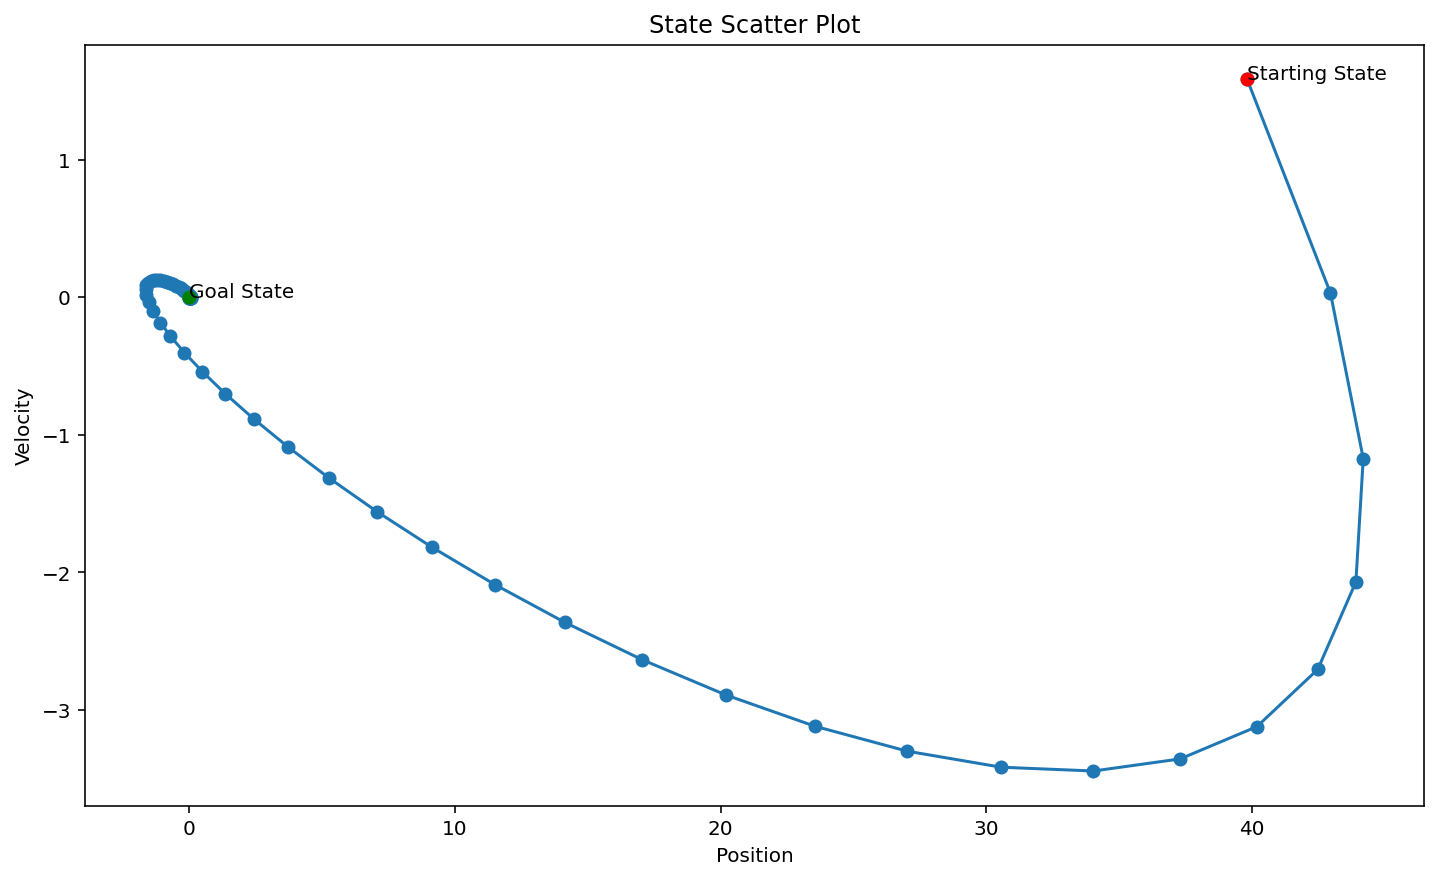

In [18]:
fig, ax = plt.subplots()

ax.scatter(states[:,0],states[:,1])
ax.plot(states[:,0],states[:,1])
ax.plot(states[0][0],states[0][1],'ro')
ax.plot(0,0,'go')
ax.annotate('Starting State',(states[0][0],states[0][1]))
ax.annotate('Goal State',(0,0))
ax.set_title('State Scatter Plot')
ax.set_ylabel('Velocity')
ax.set_xlabel('Position')

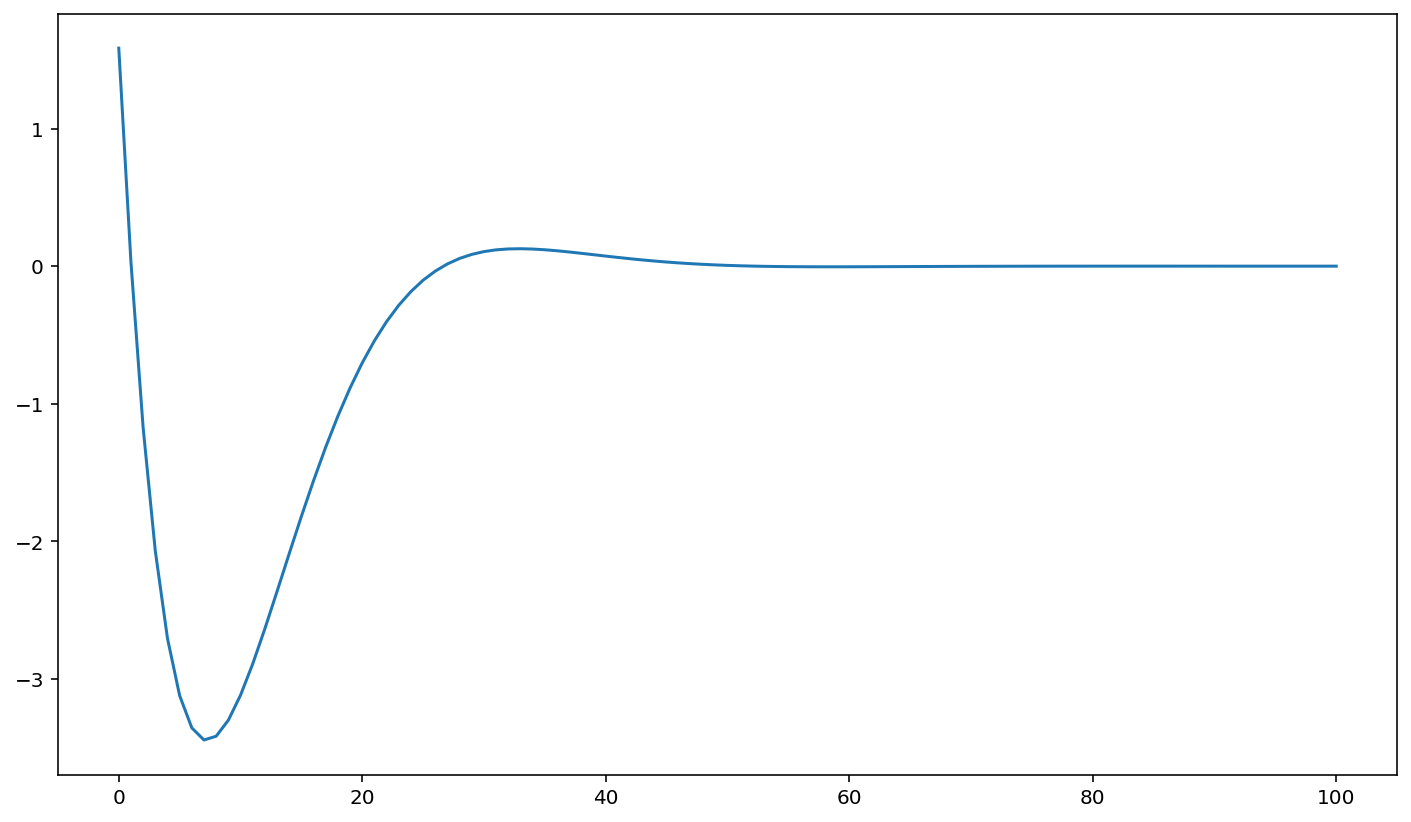

In [20]:
plt.plot(states[:,1])

Text(0.5, 1.0, 'Cost-to-go vs. time')

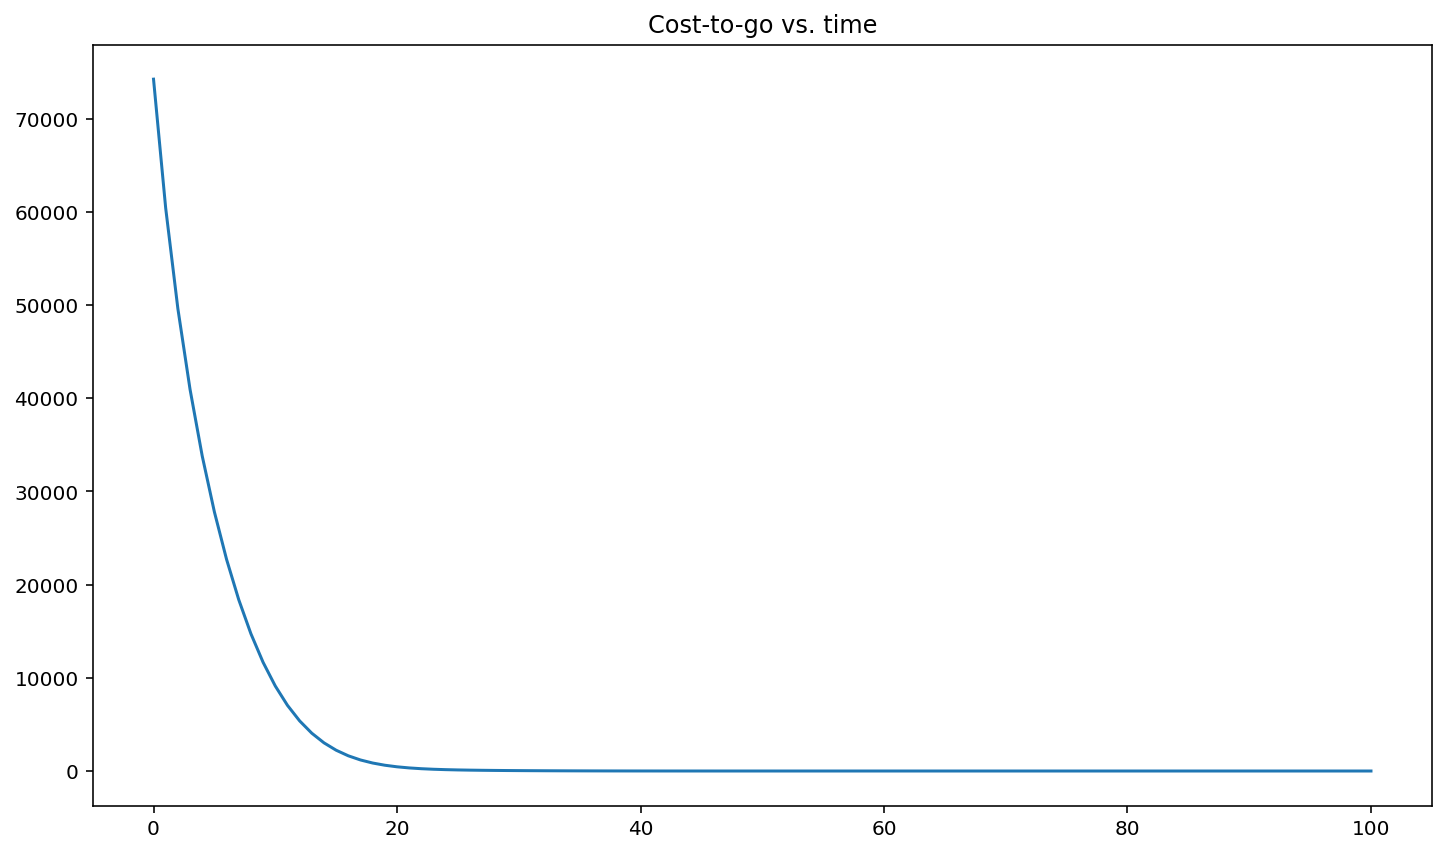

In [14]:
plt.plot(test.costs)
plt.title('Cost-to-go vs. time')

Now we can add additive noise to the system with the terms B_w and w

In [21]:

test_noise = LQR_1d(noise=True,starting_point=np.array([test.init_position, test.init_velocity]))
states_noise = np.array(test_noise.state)
print('Initial state: {}'.format(test_noise.state))
for _ in range(100):
    test_noise.step()
    states_noise=np.vstack((states_noise,test_noise.state))
print('Final state: {}'.format(test_noise.state))
print('||u||_inf: {}'.format(np.amax(test_noise.actions_taken)))

P: [[ 10.17136717  46.14267151]
 [ 46.14267151 376.04871128]]
Kh: [[-0.02779994 -0.28276337]]
Initial state: [39.80600407  1.58401944]
Final state: [-0.0287837   0.00261128]
||u||_inf: 2.8420414939366885


Text(0.5, 0, 'Position')

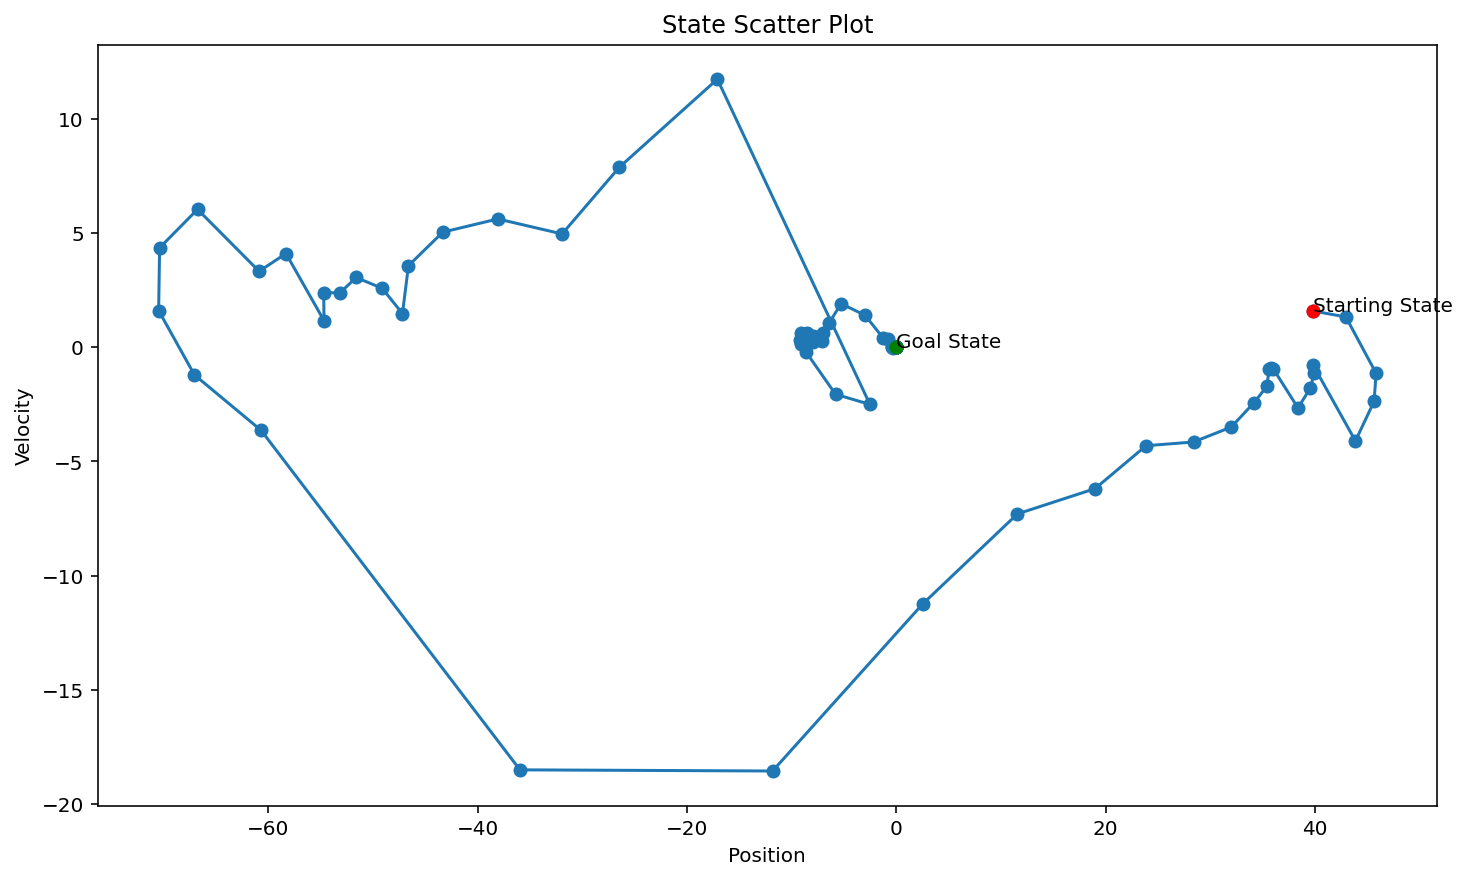

In [22]:
fig, ax = plt.subplots()

ax.scatter(states_noise[:,0],states_noise[:,1])
ax.plot(states_noise[:,0],states_noise[:,1])
ax.plot(states_noise[0][0],states_noise[0][1],'ro')
ax.plot(0,0,'go')
ax.annotate('Starting State',(states_noise[0][0],states_noise[0][1]))
ax.annotate('Goal State',(0,0))
ax.set_title('State Scatter Plot')
ax.set_ylabel('Velocity')
ax.set_xlabel('Position')

Text(0.5, 1.0, 'Cost-to-go vs. time')

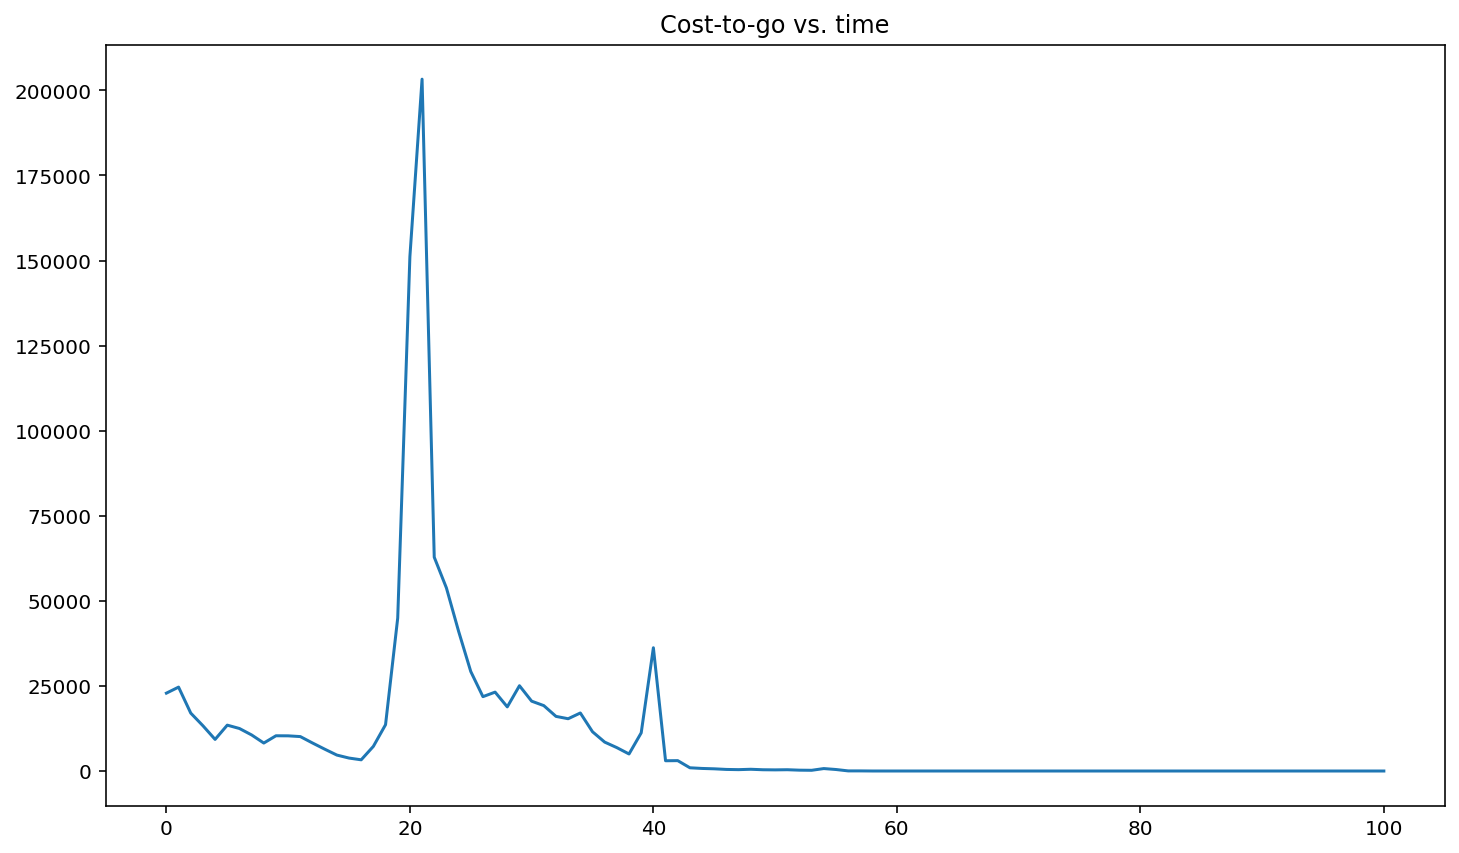

In [23]:
plt.plot(test_noise.costs)
plt.title('Cost-to-go vs. time')